# Градиентный бустинг

#### 1. Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

Загрузим данные:

In [1]:
import pandas as pd

df = pd.read_csv('features.csv', index_col = 'match_id')

Удалим признаки, которых нет в тестовой выборке:

In [2]:
columns_to_drop = ['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 
                   'barracks_status_dire']
for column in columns_to_drop:
    df.drop(column, axis = 1, inplace = True)

#### 2. Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

Найдем признаки с пропусками в данных. Не будем использовать функцию count(), а автоматически найдем имена признаков с пропусками):

In [3]:
missing_data_columns = list(filter(lambda column: df[column].isna().values.any(), df.columns))

print(missing_data_columns)

['first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time']


Первые два признака с пропусками `first_blood_time` и `first_blood_team`. Пропуски в них логичны, т.к. не обязательно в каждой игре "первая кровь" происходила в течение первых 5 минут игры, про которые у нас есть данные.

В целом, можно заметить, что пропуски связаны с событиями "первая кровь" и "приобретение предметов". Это можно легко объяснить именно тем, что эти события просто не произошли за первые пять минут игры.

#### 3. Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

Не будем заменять пропуски на 0, т.к. это не логично. Эти признаки - время, а значит если мы заменим пустые значения в них на 0, это будет означать, что события произошли в самом начале игры. Но в действительности они не произошли. Так что заменим их на -1.

In [4]:
df.fillna(-1, inplace = True)

#### 4. Какой столбец содержит целевую переменную? Запишите его название.

Согласно документации - `radiant_win`. Вот его значения:

In [5]:
print(df['radiant_win'].unique())

[1 0]


#### Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

Подготовим матрицы c признаками для обучения:

In [6]:
import numpy as np

x = df.as_matrix(columns = df.columns.difference(['radiant_win']))
y = np.ravel(df.as_matrix(columns = ['radiant_win']))

Обучим градиентный бустинг и посмотрим его качество с помощью AUC-ROC и кросс-валидации для разного числа деревьев:

In [7]:
import time
import datetime
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

kfold = KFold(n_splits = 5, shuffle = True)
data_split = list(kfold.split(x))

roc_aucs = []
working_times = []
n_estimators = list(range(10, 251, 10))

def measure_gbc(n, learning_rate = 0.1, max_depth = 3):
    n_roc_aucs = []
    start_time = datetime.datetime.now()
    
    for train_index, test_index in data_split:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        gbclf = GradientBoostingClassifier(n_estimators = n, learning_rate = learning_rate,
                                           max_depth = max_depth)
        gbclf.fit(x_train, y_train)
        y_score = gbclf.predict_proba(x_test)[:, 1]
        roc_auc = roc_auc_score(y_true = y_test, y_score = y_score)
        n_roc_aucs.append(roc_auc)

    roc_auc = np.mean(n_roc_aucs)
    working_time = datetime.datetime.now() - start_time
    return roc_auc, working_time
    
for n in n_estimators:
    roc_auc, working_time = measure_gbc(n)
    roc_aucs.append(roc_auc)
    working_times.append(working_time)
    print(f"n_estimators = {n}, roc_auc = {roc_auc}, time = {working_time}")

n_estimators = 10, roc_auc = 0.6647663489746313, time = 0:00:39.457429
n_estimators = 20, roc_auc = 0.6825735847213263, time = 0:01:10.378600
n_estimators = 30, roc_auc = 0.6901836602702403, time = 0:01:45.939393
n_estimators = 40, roc_auc = 0.6944579347951023, time = 0:02:24.659465
n_estimators = 50, roc_auc = 0.6978675524096297, time = 0:02:47.372763
n_estimators = 60, roc_auc = 0.7005126037101042, time = 0:04:17.478760
n_estimators = 70, roc_auc = 0.7024448631651243, time = 0:07:04.563176
n_estimators = 80, roc_auc = 0.7041253821974692, time = 0:07:24.371417
n_estimators = 90, roc_auc = 0.7056720928469578, time = 0:04:33.210721
n_estimators = 100, roc_auc = 0.7067734299816308, time = 0:05:24.324671
n_estimators = 110, roc_auc = 0.7076780369721887, time = 0:05:43.466773
n_estimators = 120, roc_auc = 0.7085808454715753, time = 0:06:31.946728
n_estimators = 130, roc_auc = 0.7094237562967745, time = 0:07:39.270207
n_estimators = 140, roc_auc = 0.7101196525024956, time = 0:07:48.221477
n

##### Анализ результатов работы

В случае `30` деревьев работа алгоритма заняла:

In [8]:
index = n_estimators.index(30)
print(working_times[index])

0:01:45.939393


При этом алгоритм показал следующее значение AUC-ROC:

In [9]:
print(roc_aucs[index])

0.69018366027


Нарисуем график зависимости AUC-ROC от числа деревьев:

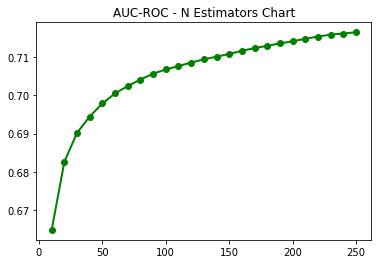

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure()
plt.title('AUC-ROC - N Estimators Chart')
plt.plot(n_estimators, roc_aucs, color = 'green', linestyle = 'solid', 
         marker = 'o', linewidth = 2)
plt.show()

Как следует из графика, прирост качества замедляется по мере увеличения числа деревьев. Не смотря на это, использование более 30 деревьев вполне оправданно. 

Попробуем разобраться что можно сделать, чтобы ускорить обучение на большом количестве дереьвев. У градиентного бустинга есть три основных параметра для тюнинга: количество деревьев, скорость обучения и максимальная глубина деревьев.

Проверим влияние скорости обучения на время обучения алгоритма при числе деревьев равном 60:

In [11]:
for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:
    roc_auc, working_time = measure_gbc(60, learning_rate = learning_rate)
    print(f"learning_rate = {learning_rate}, roc_auc = {roc_auc}, time = {working_time}")

learning_rate = 1, roc_auc = 0.7006716211176018, time = 0:05:58.737985
learning_rate = 0.5, roc_auc = 0.7094754620355662, time = 0:04:14.171295
learning_rate = 0.3, roc_auc = 0.71038435911665, time = 0:03:03.764492
learning_rate = 0.2, roc_auc = 0.7069728504555586, time = 0:03:04.700608
learning_rate = 0.1, roc_auc = 0.7005126037101042, time = 0:03:04.485157


Как видно, время работы алгоритма существенно не изменилось.

Проверим влияние максимальной глубины деревьев на скорость обучения при числе деревьев равном 60:

In [12]:
for max_depth in [3, 2, 1]:
    roc_auc, working_time = measure_gbc(60, max_depth = max_depth)
    print(f"max_depth = {max_depth}, roc_auc = {roc_auc}, time = {working_time}")

max_depth = 3, roc_auc = 0.7005126037101042, time = 0:03:01.369567
max_depth = 2, roc_auc = 0.6950462090663883, time = 0:01:55.518514
max_depth = 1, roc_auc = 0.6820302171548914, time = 0:00:58.586370


Уменьшение максимальной глубины деревьев до 2 заметно ускоряет обучение, при это качество уменьшается незначительно. Поэтому для ускорения обучения на большом количестве деревьев можно уменьшать их максимальную глубину.

# Логистическая регрессия

#### 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Загрузим и подготовим данные:

In [13]:
df = pd.read_csv('features.csv', index_col = 'match_id')

columns_to_drop = ['duration', 'tower_status_radiant', 'tower_status_dire', 'barracks_status_radiant', 
                   'barracks_status_dire']
for column in columns_to_drop:
    df.drop(column, axis = 1, inplace = True)
    
df.fillna(-1, inplace = True)

Для начала проведём нормализацию признаков, т.к. линейные методы чувствительны к масштабу исходных данных:

In [14]:
from sklearn.preprocessing import StandardScaler

heroes_ids_columns = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
                      'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
cat_columns = ['lobby_type'] + heroes_ids_columns
columns_to_scale = df.columns.difference(['radiant_win', 'start_time'] + cat_columns)

data = df.as_matrix(columns = columns_to_scale)
scaler = StandardScaler()
data = scaler.fit_transform(data)
for i, column in enumerate(columns_to_scale):
    df[column] = data[:, i]

Подготовим матрицы с признаками для обучения:

In [15]:
x = df.as_matrix(columns = df.columns.difference(['radiant_win', 'start_time']))
y = np.ravel(df.as_matrix(columns = ['radiant_win']))

Построим логистическую регрессию для разных значений параметра регуляризации C. Будем использовать ту же кросс-валидацию, что и для градиентного бустинга чтобы можно было сравнивать значения AUC-ROC:

In [16]:
from sklearn.linear_model import LogisticRegression

roc_aucs = []
cs = np.power(10.0, np.arange(-6, 6))

def measure_lr(c):
    n_roc_aucs = []
    start_time = datetime.datetime.now()
    
    for train_index, test_index in data_split:
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        lr = LogisticRegression(C = c)
        lr.fit(x_train, y_train)
        y_score = lr.predict_proba(x_test)[:, 1]
        roc_auc = roc_auc_score(y_true = y_test, y_score = y_score)
        n_roc_aucs.append(roc_auc)

    roc_auc = np.mean(n_roc_aucs)
    working_time = datetime.datetime.now() - start_time
    return roc_auc, working_time
    
for c in cs:
    roc_auc, working_time = measure_lr(c)
    roc_aucs.append(roc_auc)
    print(f"C = {c}, roc_auc = {roc_auc}, time = {working_time}")

C = 1e-06, roc_auc = 0.6600091722088369, time = 0:00:03.592894
C = 1e-05, roc_auc = 0.6957045993305769, time = 0:00:04.611708
C = 0.0001, roc_auc = 0.7109203000985014, time = 0:00:08.761236
C = 0.001, roc_auc = 0.7157764203388917, time = 0:00:15.511621
C = 0.01, roc_auc = 0.7159212130720893, time = 0:00:19.348066
C = 0.1, roc_auc = 0.7158813480992721, time = 0:00:22.016497
C = 1.0, roc_auc = 0.7158792164517782, time = 0:00:21.644576
C = 10.0, roc_auc = 0.715881121129817, time = 0:00:19.587485
C = 100.0, roc_auc = 0.7158826662574965, time = 0:00:20.438621
C = 1000.0, roc_auc = 0.71587648053025, time = 0:00:22.011590
C = 10000.0, roc_auc = 0.7158775194090932, time = 0:00:22.067916
C = 100000.0, roc_auc = 0.7158777270341311, time = 0:00:21.931253


Логистическая регрессия показывает высокое качество сравнимое с градиентным бустингом на числе дервьев более 250. При этом скорость обучения существенно выше.

Построим график зависимости качества логистической регрессии AUC-ROC от логарифма параметра регуляризации С:

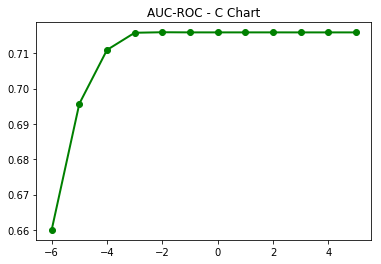

In [17]:
import math

plt.figure()
plt.title('AUC-ROC - C Chart')
plt.plot(list(map(lambda v: math.log10(v), cs)), roc_aucs, color = 'green', linestyle = 'solid', 
         marker = 'o', linewidth = 2)
plt.show()

Как видно из графика, параметр регуляризации С в данном случае не оказывает существенного влияния на качество логистической регрессии. Наилучшее качество получается при C = 0.01.

#### 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

Удалим категориальные признаки:

In [18]:
df_cat = df.copy(deep = True)
for column in cat_columns:
    df_cat.drop(column, axis = 1, inplace = True)

Подготовим матрицы с данными для обучения:

In [19]:
x = df_cat.as_matrix(columns = df_cat.columns.difference(['radiant_win', 'start_time']))
y = np.ravel(df_cat.as_matrix(columns = ['radiant_win']))

Проверим как удаление категориальных признаков повлияло на логистическую регрессию:

In [20]:
roc_aucs = []

for c in cs:
    roc_auc, working_time = measure_lr(c)
    roc_aucs.append(roc_auc)
    print(f"C = {c}, roc_auc = {roc_auc}, time = {working_time}")

C = 1e-06, roc_auc = 0.6905443007976004, time = 0:00:01.954221
C = 1e-05, roc_auc = 0.6964099852845461, time = 0:00:02.392518
C = 0.0001, roc_auc = 0.710948103093101, time = 0:00:04.011072
C = 0.001, roc_auc = 0.715784672758926, time = 0:00:07.237495
C = 0.01, roc_auc = 0.715919058697688, time = 0:00:09.811781
C = 0.1, roc_auc = 0.7158812093401765, time = 0:00:10.354296
C = 1.0, roc_auc = 0.7158764791228169, time = 0:00:10.398416
C = 10.0, roc_auc = 0.7158760236316225, time = 0:00:10.479774
C = 100.0, roc_auc = 0.7158760236486514, time = 0:00:10.414042
C = 1000.0, roc_auc = 0.7158760067047885, time = 0:00:10.293989
C = 10000.0, roc_auc = 0.7158760067034378, time = 0:00:10.350027
C = 100000.0, roc_auc = 0.7158760067034378, time = 0:00:10.413510


После удаления категориальных признаков качество практически не изменилось, значит они в том виде, что мы их использовали, не имеют существенного значения для качества модели. Лучшее качество по-прежнему достигается при C = 0.01.

#### 3. На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

Сколько всего идентификаторов героев существует:

In [21]:
heroes_ids = np.unique(list(map(lambda c: df[c].unique(), heroes_ids_columns)))
print(len(heroes_ids))

108


#### 4. Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

Построим матрицу таких признаков:

In [22]:
N = np.max(heroes_ids)
x_pick = np.zeros((df.shape[0], N))

for i, match_id in enumerate(df.index):
    for p in range(5):
        x_pick[i, df.loc[match_id, 'r%d_hero' % (p+1)] - 1] = 1
        x_pick[i, df.loc[match_id, 'd%d_hero' % (p+1)] - 1] = -1

Добавим ее к набору данных:

In [23]:
for i in range(N):
    df_cat[f"Hero{i}"] = x_pick[:, i]

#### 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

Подготовим матрицы с данными для обучения:

In [24]:
x = df_cat.as_matrix(columns = df_cat.columns.difference(['radiant_win', 'start_time']))
y = np.ravel(df_cat.as_matrix(columns = ['radiant_win']))

Посмотрим как это преобразование повлияло на обучение:

In [25]:
roc_aucs = []

for c in cs:
    roc_auc, working_time = measure_lr(c)
    roc_aucs.append(roc_auc)
    print(f"C = {c}, roc_auc = {roc_auc}, time = {working_time}")

C = 1e-06, roc_auc = 0.693050718738124, time = 0:00:02.651030
C = 1e-05, roc_auc = 0.7006059450612709, time = 0:00:03.089203
C = 0.0001, roc_auc = 0.724687038382984, time = 0:00:05.287139
C = 0.001, roc_auc = 0.7457215406423588, time = 0:00:09.635899
C = 0.01, roc_auc = 0.7511369536477372, time = 0:00:15.824552
C = 0.1, roc_auc = 0.7513495315423777, time = 0:00:21.162533
C = 1.0, roc_auc = 0.7513326614865894, time = 0:00:22.194791
C = 10.0, roc_auc = 0.7513303352994122, time = 0:00:22.363398
C = 100.0, roc_auc = 0.7513298840157099, time = 0:00:22.324373
C = 1000.0, roc_auc = 0.7513300195667766, time = 0:00:22.302132
C = 10000.0, roc_auc = 0.7513299602424944, time = 0:00:22.214095
C = 100000.0, roc_auc = 0.7513299284793127, time = 0:00:22.463800


Качество обучения существенно взоросло. В данном случае лучший параметр C = 0.1. Это можно объяснить тем, что само значение идентификатора мало влияло на результат, значительно важнее был просто факт присутствия героя в игре.

#### 6. Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

Судя по AUC-ROC для этой задачи лучше всего работает логистическая регрессия.

Обучим модель на обучающей выборке с C = 0.1:

In [26]:
lr = LogisticRegression(C = 0.1)
lr.fit(x, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Загрузим и подготовим тестовую выборку:

In [27]:
df = pd.read_csv('features_test.csv', index_col = 'match_id')

df.fillna(-1, inplace = True)

data = df.as_matrix(columns = columns_to_scale)
data = scaler.transform(data)
for i, column in enumerate(columns_to_scale):
    df[column] = data[:, i]
        
x_pick = np.zeros((df.shape[0], N))
for i, match_id in enumerate(df.index):
    for p in range(5):
        x_pick[i, df.loc[match_id, 'r%d_hero' % (p+1)] - 1] = 1
        x_pick[i, df.loc[match_id, 'd%d_hero' % (p+1)] - 1] = -1
for i in range(N):
    df[f"Hero{i}"] = x_pick[:, i]
    
for column in cat_columns:
    df.drop(column, axis = 1, inplace = True)

Получим предсказания для тестовой выборки:

In [28]:
proba = lr.predict_proba(df.as_matrix(columns = df.columns.difference(['start_time'])))
print(proba)

[[ 0.16161213  0.83838787]
 [ 0.2262069   0.7737931 ]
 [ 0.79612991  0.20387009]
 ..., 
 [ 0.77383724  0.22616276]
 [ 0.37848084  0.62151916]
 [ 0.5847073   0.4152927 ]]


Видно, что вероятности адекватны:

In [29]:
dire_proba = proba[:, 0]
rad_proba = proba[:, 1]

print(f"Dire: min = {np.min(dire_proba)}, max = {np.max(dire_proba)}, Unique values = {np.unique(dire_proba).size}")
print(f"Radiant: min = {np.min(dire_proba)}, max = {np.max(dire_proba)}, Unique values = {np.unique(dire_proba).size}")

Dire: min = 0.003517865110973739, max = 0.9907292813617132, Unique values = 17177
Radiant: min = 0.003517865110973739, max = 0.9907292813617132, Unique values = 17177


Подготовим и сохраним файл для Kaggle:

In [ ]:
df_test = pd.DataFrame()
df_test['match_id'] = df.index.values
df_test['radiant_win'] = rad_proba

df_test.to_csv('kaggle_results.csv', index = False)